# Use dataset <u>__7__</u> as test set

In [1]:
from inception_v4 import InceptionV4
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dropout, concatenate, Input, Activation, normalization, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model, model_from_json, Input
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import SaveModelOnMAE_tail, generate_generator, read_image_and_K_from_dir, read_48_points


%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
random.seed(7)
net = 'inceptionV4'
with_K = 'tail'
tb = TensorBoard(log_dir='./logs/logs_'+with_K+'_K')

# Dataset
dir_path = './data/csv_files'
train_paths, train_labels, train_K, test_paths, test_labels, test_K = read_image_and_K_from_dir(dir_path, idx_test=7)


indexes_rand = list(range(len(train_K)))
random.shuffle(indexes_rand)
train_paths, train_labels, train_K = np.asarray(train_paths)[indexes_rand].tolist(), np.asarray(train_labels)[indexes_rand].tolist(), np.asarray(train_K)[indexes_rand].tolist()

idx_validate = np.loadtxt('./data/validation_selection_index.txt').astype(int)
validate_paths, validate_labels, validate_K = np.asarray(test_paths)[idx_validate].tolist(), np.asarray(test_labels)[idx_validate].tolist(), np.asarray(test_K)[idx_validate].tolist()

indexes_rand = list(range(len(test_K)))
random.shuffle(indexes_rand)
test_paths, test_labels, test_K = np.asarray(test_paths)[indexes_rand].tolist(), np.asarray(test_labels)[indexes_rand].tolist(), np.asarray(test_K)[indexes_rand].tolist()

test_paths_48, test_labels_48, test_K_48 = read_48_points(
    dir_path='./data/csv_files', dir_points='./data/48_points', idx_test=7
)
test_paths_48, test_labels_48, test_K_48 = np.squeeze(test_paths_48).tolist(), np.squeeze(test_labels_48).tolist(), np.squeeze(test_K_48).tolist()
print('\tpath\tlabel\tK')
print('train:\t{}\t{}\t{}'.format(len(train_paths), len(train_labels), len(train_K)))
print('val:\t{}\t{}\t{}'.format(len(validate_paths), len(validate_labels), len(validate_K)))
print('test:\t{}\t{}\t{}'.format(len(test_paths), len(test_labels), len(test_K)))

Using TensorFlow backend.


Reading 	train and test set 	from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
Reading 	validation set 		from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
	path	label	K
train:	1310850	1310850	1310850
val:	64	64	64
test:	84600	84600	84600


In [2]:
base_model = InceptionV4(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
flat = Flatten()(base_model.output)
flat_len = 1
for i in range(1, len(base_model.output.shape)):
    flat_len *= int(base_model.output.shape[i])
K_len = flat_len // 3
input_K = Input((K_len, ))
K_flow = Activation(activation='linear')(input_K)
K_flow = input_K
x = concatenate([flat, K_flow])
x = Dense(2048, activation='relu')(x)
# x = normalization.BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(inputs=[*base_model.inputs, input_K], outputs=x, name=net)
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
batch_size_train = 32
epochs_per_iteration = 64
batch_size_validate = len(validate_labels)

save_dir_weights = './weights/weights_' + with_K + '_K/'
if not os.path.exists(save_dir_weights):
    os.mkdir(save_dir_weights)

checkpointer_best = ModelCheckpoint(
    filepath=save_dir_weights + net + '.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
saver_MAE = SaveModelOnMAE_tail()
print('Training ...')
train_generator = generate_generator(train_paths, train_labels, train_K, batch_size_train, net=net, with_K=with_K, K_len=K_len)
validate_generator = generate_generator(validate_paths, validate_labels, validate_K, batch_size_validate, net=net, with_K=with_K, K_len=K_len)
history = model.fit_generator(
    train_generator, steps_per_epoch = np.ceil(len(train_paths)/batch_size_train/epochs_per_iteration),
    epochs=epochs_per_iteration * 2,
    validation_data=validate_generator, validation_steps=1,
    verbose=1, callbacks=[checkpointer_best, saver_MAE, tb]
)

Training ...
Epoch 1/128
641/641 [==============================] - 172s 269ms/step - loss: 41.7235 - val_loss: 1168.1615

Epoch 00001: val_loss improved from inf to 1168.16150, saving model to ./weights/weights_tail_K/inceptionV4.hdf5
Epoch 2/128
641/641 [==============================] - 149s 233ms/step - loss: 3.8730 - val_loss: 10297366528.0000

Epoch 00002: val_loss did not improve from 1168.16150
Epoch 3/128
641/641 [==============================] - 151s 236ms/step - loss: 3.2400 - val_loss: 7553268736.0000

Epoch 00003: val_loss did not improve from 1168.16150
Epoch 4/128
641/641 [==============================] - 150s 234ms/step - loss: 3.1999 - val_loss: 2022866944.0000

Epoch 00004: val_loss did not improve from 1168.16150
Epoch 5/128
641/641 [==============================] - 148s 231ms/step - loss: 2.9639 - val_loss: 12911665152.0000

Epoch 00005: val_loss did not improve from 1168.16150
Epoch 6/128
641/641 [==============================] - 147s 230ms/step - loss: 3.2175 

641/641 [==============================] - 269s 420ms/step - loss: 0.8964 - val_loss: 1.2638

Epoch 00050: val_loss did not improve from 0.93313
Epoch 51/128
641/641 [==============================] - 268s 419ms/step - loss: 0.9374 - val_loss: 4.0033

Epoch 00051: val_loss did not improve from 0.93313
Epoch 52/128
641/641 [==============================] - 269s 420ms/step - loss: 0.8086 - val_loss: 1.3783

Epoch 00052: val_loss did not improve from 0.93313
Epoch 53/128
641/641 [==============================] - 267s 417ms/step - loss: 0.8386 - val_loss: 3.0227

Epoch 00053: val_loss did not improve from 0.93313
Epoch 54/128
641/641 [==============================] - 265s 413ms/step - loss: 0.7977 - val_loss: 2.8552

Epoch 00054: val_loss did not improve from 0.93313
Epoch 55/128
641/641 [==============================] - 267s 416ms/step - loss: 0.8341 - val_loss: 2.6513

Epoch 00055: val_loss did not improve from 0.93313
Epoch 56/128
641/641 [==============================] - 268s 418m


Epoch 00101: val_loss did not improve from 0.43266
Epoch 102/128
641/641 [==============================] - 148s 231ms/step - loss: 0.3813 - val_loss: 4.9744

Epoch 00102: val_loss did not improve from 0.43266
Epoch 103/128
641/641 [==============================] - 149s 232ms/step - loss: 0.4239 - val_loss: 3.2443

Epoch 00103: val_loss did not improve from 0.43266
Epoch 104/128
641/641 [==============================] - 149s 232ms/step - loss: 0.4325 - val_loss: 2.7598

Epoch 00104: val_loss did not improve from 0.43266
Epoch 105/128
641/641 [==============================] - 147s 229ms/step - loss: 0.4365 - val_loss: 2.6600

Epoch 00105: val_loss did not improve from 0.43266
Epoch 106/128
641/641 [==============================] - 149s 232ms/step - loss: 0.5118 - val_loss: 2.9705

Epoch 00106: val_loss did not improve from 0.43266
Epoch 107/128
641/641 [==============================] - 148s 231ms/step - loss: 0.4005 - val_loss: 2.3794

Epoch 00107: val_loss did not improve from 0.

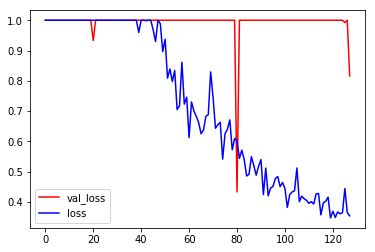

In [6]:
vl, l = history.history['val_loss'], history.history['loss']
vl, l = np.asarray(vl), np.asarray(l)
vl[vl > 1], l[l > 1] = 1, 1

plt.plot(vl, 'r')
plt.plot(l, 'b')
plt.legend(['val_loss', 'loss'])
plt.show()

(47,)


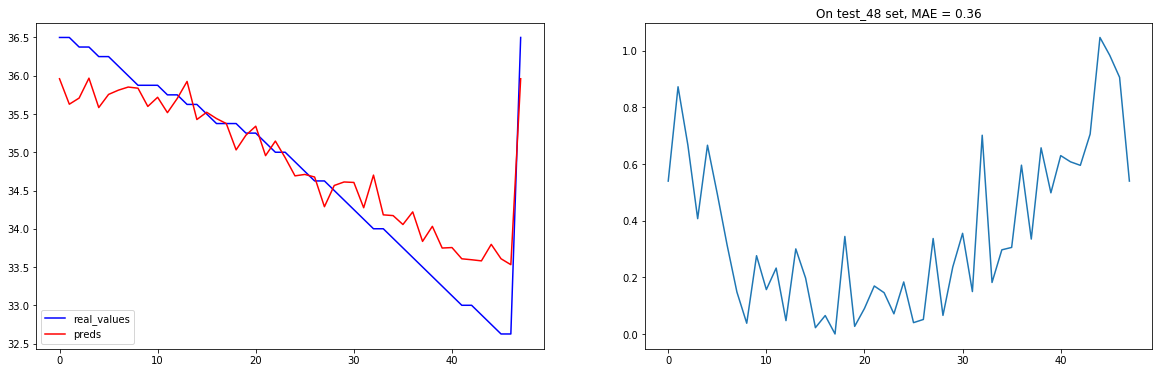

In [10]:
# test
# model = load_model('./weights/weights_tail_K/inceptionV4_tail_K_MAE0.433.hdf5')
generator_for_test = generate_generator(test_paths_48, test_labels_48, test_K_48, 48, net=net, with_K=with_K, K_len=K_len)
X_test, Y_test = generator_for_test.__next__()
preds = np.squeeze(model.predict(X_test))
fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
ax0.plot(Y_test, 'b')
ax0.plot(preds, 'r')
ax0.legend(['real_values', 'preds'])
ax1.plot(np.abs(preds - Y_test))
MAE = round(np.mean(abs(preds - Y_test)), 3)
ax1.set_title('On test_48 set, MAE = {}'.format(MAE))
print(np.unique(preds).shape)
plt.show()

In [11]:
import pandas as pd
label_pred = np.hstack([np.asarray(range(Y_test.shape[0])).reshape(-1, 1), Y_test.reshape(-1, 1), preds.reshape(-1, 1)])
label_pred = pd.DataFrame(label_pred)
label_pred.to_csv(
    os.path.join('preds', 'preds_' + with_K + '_K', '_'.join([net, with_K, 'K_MAE', str(MAE) + '.txt'])),
    index=None,
    header=['index', 'label', 'prediction']
)